# Lecture 1: Introduction
This notebook is a part of the [Algorithmic Fairness, Accountability and Ethics (Spring 2024)](https://learnit.itu.dk/course/view.php?id=3022793) at [IT-University of Copenhagen](https://itu.dk/)


Today you have seen the example of bias in [ImageNet dataset](https://www.image-net.org/). Let's see if we can identify bias using other datasets and models.

We are going to work with the [CLIP](https://openai.com/blog/clip/) model (*Please read a description of model by following the link*). A little overview of the model:
1. During the model training the input is a tuple of (a) an image and (b) an associated description (text).
2. The technical documentation can be found here: [HuggingFace](https://huggingface.co/openai/clip-vit-base-patch16)
3. Note that the model weights aound 600MB. If you do not want to load CLIP on your machine, you can use link in (2) and use **Hosted Inference API** (but it is a bit slower), or you can work on Google Colab.
4. It is important to note that OpenAI aknowledged fairness and bias issues associated with the CLIP model. 
5. We are going to see how gender bias manifests itself.

The [dataset](https://huggingface.co/datasets/SDbiaseval/identities-sd-1.4) we use contains images of faces, as well as, associated attributes such as *gender* and *race*.

## 1. Setup
__If you have trouble loading datasets after having installed the package (```pip install datasets```), pleae restart your kernel and try again__

In [1]:
# Here are the packages that you need to install 
import pandas as pd
from transformers import CLIPProcessor, CLIPModel # pip install transformers
from datasets import load_dataset ## pip install datasets
import matplotlib.pyplot as plt
import numpy as np

/home/thejarmanitor/miniconda3/envs/algfair/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Download the dataset
dataset = load_dataset("SDbiaseval/identities-sd-1.4")
# 2. Download + set up the model and processor (if you want to know more about these, read the Huggingface documentation)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

config.json: 100%|██████████| 4.10k/4.10k [00:00<00:00, 4.19MB/s]
pytorch_model.bin: 100%|██████████| 599M/599M [01:25<00:00, 6.98MB/s] 
tokenizer_config.json: 100%|██████████| 905/905 [00:00<00:00, 1.15MB/s]
vocab.json: 100%|██████████| 961k/961k [00:00<00:00, 3.11MB/s]
merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 5.93MB/s]
tokenizer.json: 100%|██████████| 2.22M/2.22M [00:00<00:00, 5.04MB/s]
special_tokens_map.json: 100%|██████████| 389/389 [00:00<00:00, 794kB/s]


## 2. Making Predictions
To access a record/sample you can use the snippet below. Here we access the first image in the dataset. As you can see it is a dict:

In [4]:
sample = dataset["train"][0]
sample

{'ethnicity': 'African-American',
 'gender': 'man',
 'no': 1,
 'image_path': 'Photo_portrait_of_an_African-American_man_at_work/Photo_portrait_of_an_African-American_man_at_work_1.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>}

In [11]:
len(dataset["train"])

680

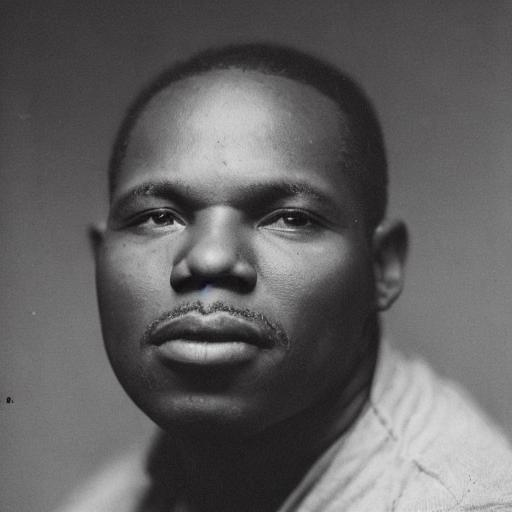

In [6]:
## To view an image you can simply do the following:
sample["image"]
## To access gender
# sample["gender"]

**CLIP allows us to specify arbitrary categories:**
* Along with the input image, we can pass these categories
* The model returns a probability that the picture belongs to one of the specified categories.
Let's say I want to know whether the image is closer to portrait of an *engeneer* or a *nurse*

In [5]:
## Create an input the the model
labels = ["a photo of an scientist", "a photo of a nurse"]
image = sample["image"]
inputs = processor(text=labels, 
                    images=image, return_tensors="pt", padding=True)

Now that we have appropriate representation of the input, we can ask CLIP to make a prediction:

In [9]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
probs = probs.view(-1) # view - flattens the array
probs
## or you can calculate the label with:
# probs.argmax()

tensor([0.9556, 0.0444])

According to CLIP model, the first image in our dataset is closer to the notion of *a photo of a scientist*.

## 3. Your Task
#### 3.1. Simple auditing of CLIP
Now we want to know if there is a difference between predictions given to females and males images (when it comes to the *a photo of a scientist* and *a photo of a nurse* categories). This is where you come in:
1. Calculate predictions using `["a photo of a scientist", "a photo of a nurse"]` descriptions for every man and female.
2. Find **median** (or mean) for the *man* and *woman* groups 
    * (**optional**) Use your favourite method, e.g. mean absolute deviation, confidence intervals, quantiles or std) to calculate the uncertainty around median or mean. 
3. Plot the results and describe what you see.

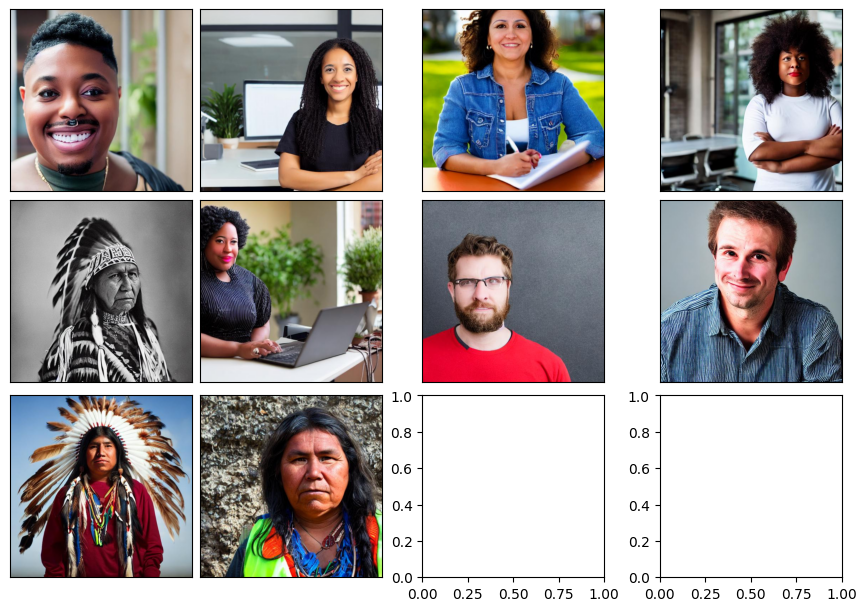

In [39]:
## your code here

np.random.seed(42)

sample_sizes = [10, 50, 500]

sample_numbers = np.random.randint(0, len(dataset["train"]), size=sample_sizes[0])

sample = dataset["train"][sample_numbers]

fig, axs = plt.subplots(3,4, figsize=(9,6), layout="compressed")
i = 0
for ax in axs.ravel():
    if i == sample_sizes[0]:
        break
    ax.imshow(sample["image"][i])
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
plt.show()



In [49]:
labels = ["a photo of a scientist", "a photo of a nurse"]


prediction_results = {
    "men": [],
    "women": [],
    "nb/ns": []
}
for i in range(sample_sizes[0]):
    image = sample["image"][i]
    inputs = processor(text=labels, 
                    images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
    probs = probs.view(-1) # view - flattens the array
    match sample["gender"][i]:
        case "man":
            prediction_results["men"].append(probs)
        case "woman":
            prediction_results["women"].append(probs)
        case _:
            prediction_results["nb/ns"].append(probs)

10
50
500


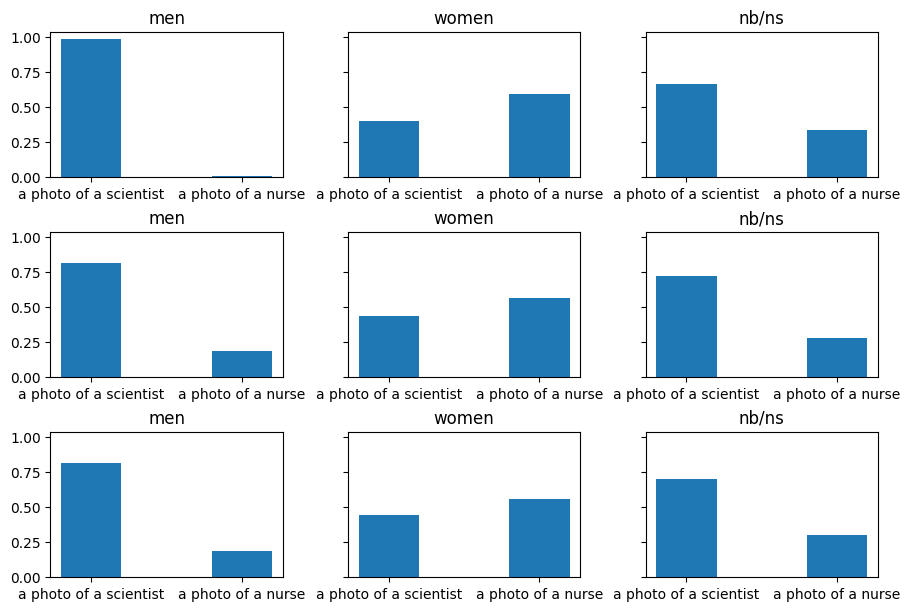

In [91]:
np.random.seed(42)

fig, ax = plt.subplots(1,3,figsize=(9,6), layout="compressed", sharey=True)
for i in range(len(sample_sizes)):
    sample_numbers = np.random.randint(0, len(dataset["train"]), size=sample_sizes[i])
    print(len(sample_numbers))
    sample = dataset["train"][sample_numbers]
    
    prediction_results = {
    "men": [],
    "women": [],
    "nb/ns": []
    }
    for h in range(sample_sizes[i]):
        image = sample["image"][h]
        inputs = processor(text=labels, 
                        images=image, return_tensors="pt", padding=True)
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1).detach() # this gives you the probabilities
        probs = probs.view(-1) # view - flattens the array
        match sample["gender"][h]:
            case "man":
                prediction_results["men"].append(probs)
            case "woman":
                prediction_results["women"].append(probs)
            case _:
                prediction_results["nb/ns"].append(probs)
    
    x = np.arange(len(prediction_results.keys()))
    width=0.4 
    for j, (key, value) in enumerate(prediction_results.items()):
        ax[i].bar(x=, height=np.mean(np.asarray(value),axis=0), width=0.4)
        ax[i].set_title(key)
    # print(i, key, value)
plt.show()

In [76]:
for (key, value) in prediction_results.items():
    print(value)

[tensor([0.9890, 0.0110])]
[tensor([0.7854, 0.2146]), tensor([0.2617, 0.7383]), tensor([0.1675, 0.8325])]
[tensor([0.7478, 0.2522]), tensor([0.3561, 0.6439]), tensor([0.7955, 0.2045]), tensor([0.9901, 0.0099]), tensor([0.7203, 0.2797]), tensor([0.3613, 0.6387])]


#### 3.2. Female vs Male Concepts
In the paper [Gender Bias in Word Embeddings:
A Comprehensive Analysis of Frequency, Syntax, and Semantics](https://arxiv.org/pdf/2206.03390.pdf), the authors prove that NLP algorithms inherit bias when it comes to gender (i.e. some words become more *male-associated* and some become more *female-associated*). Let's check whether CLIP has similar biases:
1. Go to the **Appendix A.1** of the paper mentined above. You will find a list of male-/female- associated words. 
2. Use any of them to specify your own version of `["a photo of a scienntist", "a photo of a nurse"]`. You can come up with any descriptions you want and you can use more description (more than 2).
3. Perform Similar analysis as in **Section 3.1**
4. Does your example have any difference between *man* and *woman* scores.


In [ ]:
# your code here

## 3.3. Neutral Concepts
Choose descriptions that (in your opinion) are neutral and perform the analysis in **Section 3.1** one more time


In [ ]:
# your code here